In [48]:
# import utils
from typing import Any
import torch as t
import numpy as np
import itertools
import matplotlib.pyplot as plt
# from functools import partial
%matplotlib inline

In [49]:
# parameters for top-k distribution
rng = np.random.RandomState(0)
n = 10
k = 5

In [50]:
# generate random parameters for the distribution
theta = rng.randn(n)
print(theta)

[ 1.76405235  0.40015721  0.97873798  2.2408932   1.86755799 -0.97727788
  0.95008842 -0.15135721 -0.10321885  0.4105985 ]


In [51]:
# create all possible_states:
combs = list(itertools.combinations(range(n), k))
n_states = len(combs)
assert n_states == np.math.factorial(n)/(np.math.factorial(k)*np.math.factorial(n-k))
print('Number of possible states:', n_states)
mat_x = np.zeros((len(combs), n))
for i in range(n_states):
    mat_x[i, combs[i]] = 1.

print(mat_x)


Number of possible states: 252
[[1. 1. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 1. 1. 1.]]


In [52]:
# put all of this in pytorch
theta_t = t.from_numpy(theta).float().requires_grad_(True)
states_t = t.from_numpy(mat_x).float()

def tow_t(_theta):
    return states_t @ _theta

def Z_t(_theta):
    return t.log(t.sum(t.exp(tow_t(_theta))))

def pmf_t(_theta):
    return t.exp(tow_t(_theta) - Z_t(_theta))


In [53]:
print(t.sum(pmf_t(theta)))  # so far so good

tensor(1.0000, dtype=torch.float64)


In [54]:
# check that prob(theta) is differentiable
# attributing random value to each state
b_t = t.abs(t.from_numpy(rng.randn(n)).float())

In [55]:
print(b_t)

tensor([0.1440, 1.4543, 0.7610, 0.1217, 0.4439, 0.3337, 1.4941, 0.2052, 0.3131,
        0.8541])


In [56]:
sorted_bt = np.sort(b_t.detach().numpy())
min_value_of_exp = np.sum((sorted_bt[:5])**2) + np.sum((sorted_bt[5:] - 1)**2)
print(min_value_of_exp)

1.1251508


In [57]:
def objective(index):
    return t.sum((states_t[index] - b_t)**2)

objective(1)

tensor(5.5104)

In [58]:
# writing explicitly the expectation of this objective summing over
# all possible states:
def expectation_t(_theta):
    _pmf = pmf_t(_theta)
    _p_values = t.stack([_pmf[i] * objective(i) for i in range(n_states)])
    return t.sum(_p_values)

In [59]:
expectation_t(theta_t)

tensor(5.2394, grad_fn=<SumBackward0>)

In [60]:
# checking that the gradient is all right
t.autograd.grad(expectation_t(theta_t), theta_t)

(tensor([ 0.2238, -0.4104, -0.0290,  0.1656,  0.0979,  0.0875, -0.4432,  0.2152,
          0.1734, -0.0808]),)

Essentially we are now solving explicitly
$\min_{\theta} \mathbb{E}_{z\sim p(z, \theta)} b^\intercal z$
where $p(z, \theta)$ is top-k distribution.

With full optimization we simply write $\mathbb{E}_{z\sim p(z, \theta)} b^\intercal z= \sum_{i=1}^{N} p(z_i, \theta) b^\intercal z_i $
summing over all possible states, where $N=\binom{n}{k}$


In [61]:
def optim_loop(min_objective, lr, momentum_factor, n_steps, reinitialize=True):
    global theta_t
    if reinitialize:
        theta_t = t.from_numpy(theta).float().requires_grad_(True)
    # let's try to optimize this expectation w.r.t. theta
    _opt = t.optim.SGD([theta_t], lr, momentum=momentum_factor)
    _hist, _hist_expectation = [], []
    for _t in range(n_steps):
        _opt.zero_grad()
        _obj = min_objective(theta_t)
        _hist.append(_obj.detach().numpy())
        _hist_expectation.append(expectation_t(theta_t).detach().numpy())
        _obj.backward()
        _opt.step()
    return _hist, _hist_expectation

In [62]:
full_optim_hist, _ = optim_loop(expectation_t, 1., 0.9, 50)

In [63]:

map_state_after_opt = np.argmax(pmf_t(theta_t).detach().numpy())
print('probability of map state', pmf_t(theta_t)[map_state_after_opt])
print(t.sum(states_t[map_state_after_opt] - b_t)**2, min_value_of_exp)  # should be the same!

probability of map state tensor(0.9986, grad_fn=<SelectBackward>)
tensor(1.2656) 1.1251508


In [64]:
print(states_t[map_state_after_opt])
print(b_t)

tensor([0., 1., 1., 0., 1., 0., 1., 0., 0., 1.])
tensor([0.1440, 1.4543, 0.7610, 0.1217, 0.4439, 0.3337, 1.4941, 0.2052, 0.3131,
        0.8541])


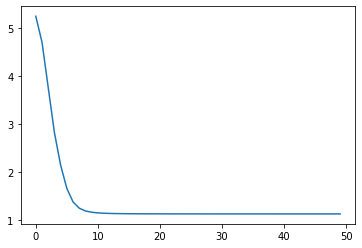

In [65]:
plt.plot(full_optim_hist)

In [66]:
# all good
# now need to do STE (i.e. sampling and ignoring constraints,
# guess treat the z's as Bernoullis') and I-MLE

# reinitialize theta with the same initial value
theta_t = t.from_numpy(theta).float().requires_grad_(True)

def sample_state_from_pdf(_theta):
    _pmft = pmf_t(_theta)
    # print(_pmft)
    # print(t.sum(_pmft))
    indx_ch = rng.choice(list(range(n_states)), p=_pmft.detach().numpy())
    return indx_ch

# just check
print([sample_state_from_pdf(theta_t) for _ in range(10)])

states_t[sample_state_from_pdf(theta_t)]

[22, 204, 71, 59, 41, 127, 60, 89, 0, 96]


tensor([1., 0., 0., 1., 1., 0., 1., 1., 0., 0.])

In [67]:
# Straight through estimator

def ste_grad(grad_out):
    return grad_out

def sample(_theta):
    _sampled_index = sample_state_from_pdf(_theta)
    return states_t[_sampled_index]

# define top-k sample dist with STE gradient

class TopKTrueSamplingSTEGrad(t.autograd.Function):

    @staticmethod
    def forward(ctx, _theta):
        return sample(_theta)

    @staticmethod
    def backward(ctx, grad_outputs):
        return ste_grad(grad_outputs)

In [68]:
def experiment(strategy, lr, momentum=0.9,
               steps=50, n_rep=50, do_plot=True):

    # redefine objective with given strategy
    def obj_st(_theta):
        return t.sum((strategy(_theta) - b_t)**2)

    hist = []
    for _ in range(n_rep):
        stoc_obj, true_obj = optim_loop(obj_st, lr, momentum, steps)
        hist.append(true_obj)

    if do_plot:
        mean = np.mean(hist, axis=0)
        plt.plot(full_optim_hist)
        plt.plot(mean)
    return hist

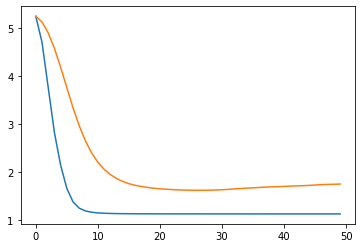

In [69]:
ste_lcs = experiment(TopKTrueSamplingSTEGrad.apply, 0.05)

In [70]:

# let's try I-MLE with faithful samples

def imle_forward(ctx, _theta, _lambda, sample_strategy):
    ctx._lambda = _lambda
    ctx._theta = _theta
    ctx._fw = sample_strategy(_theta)
    return ctx._fw

def imle_backward(ctx, grad_out, sample_strategy):
    theta_prime = ctx._theta - ctx._lambda*grad_out
    sample_prime = sample_strategy(theta_prime)
    return ctx._fw - sample_prime

class TopKTrueSamplingIMLEGradWithImplicitQ(t.autograd.Function):

    @staticmethod
    def forward(ctx, _theta, _lambda):
        return imle_forward(ctx, _theta, _lambda, sample)

    @staticmethod
    def backward(ctx, grad_outputs):
        grad = imle_backward(ctx, grad_outputs, sample)
        return grad, None

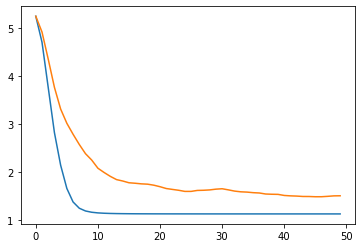

In [71]:
imle_ts_ap = TopKTrueSamplingIMLEGradWithImplicitQ.apply
imle_ts_strat = lambda _th: imle_ts_ap(_th, 2.5)

imle_ts_lcs = experiment(imle_ts_strat, 0.6)


In [72]:
def do_plots(histories, names, savename=None, figsize=(3.2, 2.5)):
    # computing also standard devs
    plt.figure(figsize=figsize)
    x_axis = list(range(50))

    means = [np.mean(np.array(his), axis=0) for his in histories]

    std_devs = [np.std(np.array(his), axis=0) for his in histories]

    plt.plot(full_optim_hist, label='Exact Gradients')

    for h, st, nm in zip(means, std_devs, names):
        line = plt.plot(h, label=nm)
        plt.fill_between(x_axis, h - st, h + st, alpha=0.5,
                         color=line[0].get_color())

    plt.legend(loc=0)
    plt.ylim((0.9, 3.5))
    plt.xlim((0, 49))
    plt.xlabel('Optimization Steps')
    plt.ylabel('Loss')
    if savename:
        plt.savefig(savename, bbox_inches='tight')

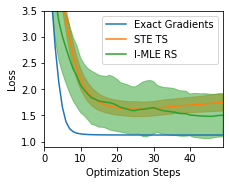

In [73]:
do_plots([ste_lcs, imle_ts_lcs], ['STE TS', 'I-MLE RS'])

In [74]:
# now let's try with MAP estimators

def map(_theta):
    arg_sort = t.argsort(_theta)[k:]
    _x = t.zeros(_theta.size())
    _x[arg_sort] = 1.
    return _x

print(theta_t)
map(theta_t)

tensor([-16.0368,  12.3110,   6.9519, -15.6514, -16.0290,  22.7876,  12.8810,
         -6.0734, -12.0341,  18.2734], requires_grad=True)


tensor([0., 1., 1., 0., 0., 1., 1., 0., 0., 1.])

In [75]:
# define top-k sample dist with STE gradient

class TopKMAPSTEGrad(TopKTrueSamplingSTEGrad):

    @staticmethod
    def forward(ctx, _theta):
        return map(_theta)

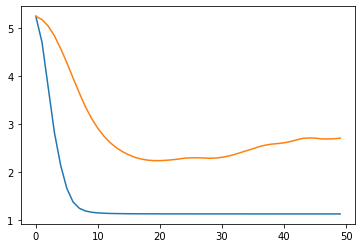

In [76]:
ste_map_lcs = experiment(TopKMAPSTEGrad.apply, 0.03, n_rep=2)

In [77]:
# MAP I-MLE

class TopKMAPIMLEGrad(t.autograd.Function):

    @staticmethod
    def forward(ctx, _theta, _lambda):
        return imle_forward(ctx, _theta, _lambda, map)

    @staticmethod
    def backward(ctx, grad_outputs):
        grad = imle_backward(ctx, grad_outputs, map)
        return grad, None

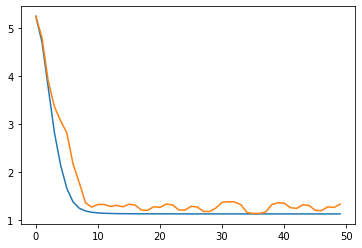

In [78]:
imle_map = lambda _th: TopKMAPIMLEGrad.apply(_th, 2.5)
imle_map_lcs = experiment(imle_map, 0.7, n_rep=2)

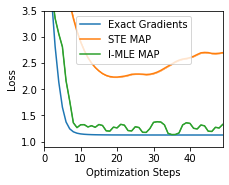

In [79]:
do_plots([ste_map_lcs, imle_map_lcs], ['STE MAP', 'I-MLE MAP'])

In [80]:
# let's try perturb and map

_k_gamma = 5.0
_tau_gamma = 1.0

def sog_th1(s=10):
    return (_tau_gamma/_k_gamma)*( np.sum([rng.gamma(1.0/_k_gamma, _k_gamma/(i+1.0)) for i in range(s)] ) - np.log(s) )

def perturb_and_map(ctx, _theta):
    if hasattr(ctx, 'eps'):
        eps = ctx.eps
    else:
        eps = t.tensor([sog_th1() for _ in range(n)])
        try: ctx.eps = eps
        except AttributeError: print('Problems with ctx')
    theta_prime = _theta + eps
    return map(theta_prime)

perturb_and_map('', theta_t)

Problems with ctx


tensor([0., 1., 1., 0., 0., 0., 1., 0., 1., 1.])

In [81]:

class TopKPerturbAndMAPIMLEGrad(t.autograd.Function):

    @staticmethod
    def forward(ctx, _theta, _lambda):
        return imle_forward(ctx, _theta, _lambda,
                            lambda _th: perturb_and_map(ctx, _th))

    @staticmethod
    def backward(ctx, grad_outputs):
        grad = imle_backward(ctx, grad_outputs,
                             lambda _th: perturb_and_map(ctx, _th))
        return grad, None

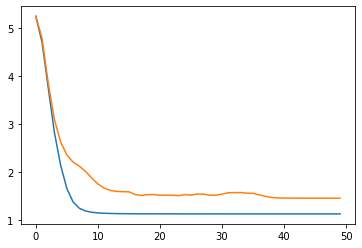

In [82]:
imle_pam = lambda _th: TopKPerturbAndMAPIMLEGrad.apply(_th, 1.)
imle_pam_lcs = experiment(imle_pam, .5, n_rep=10)

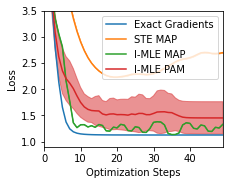

In [83]:

do_plots([ste_map_lcs, imle_map_lcs, imle_pam_lcs], ['STE MAP', 'I-MLE MAP', 'I-MLE PAM'])

In [84]:
print(theta_t)

tensor([ -8.1815,   5.3744,   5.9498, -12.6729,  -3.1046,  -0.9773,   5.9215,
          9.7921,  -5.0774,  10.3562], requires_grad=True)


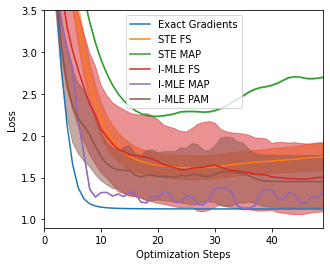

In [85]:
do_plots([ste_lcs, ste_map_lcs, imle_ts_lcs, imle_map_lcs, imle_pam_lcs],
         ['STE FS', 'STE MAP', 'I-MLE FS', 'I-MLE MAP', 'I-MLE PAM'],
         figsize=(5, 4))

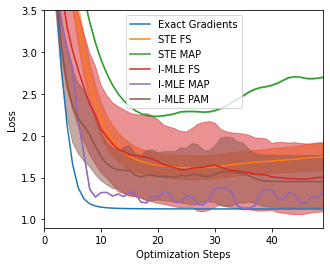

In [86]:
do_plots([ste_lcs, ste_map_lcs, imle_ts_lcs, imle_map_lcs, imle_pam_lcs],
         ['STE FS', 'STE MAP', 'I-MLE FS', 'I-MLE MAP', 'I-MLE PAM'],
         figsize=(5, 4))

In [87]:
# Wrapping up with STE PAM

class TopKPerturbAndMapSTEGrad(TopKTrueSamplingSTEGrad):

    @staticmethod
    def forward(ctx, _theta):
        return perturb_and_map(ctx, _theta)

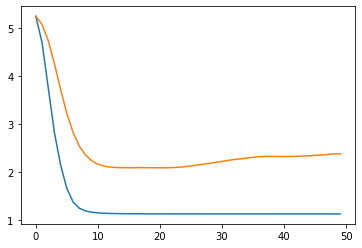

In [88]:
ste_pam_lcs = experiment(TopKPerturbAndMapSTEGrad.apply, 0.07, n_rep=50)

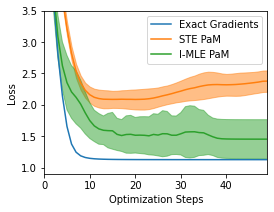

In [89]:
do_plots([ste_pam_lcs, imle_pam_lcs],
         ['STE PaM', 'I-MLE PaM'],
         figsize=(4, 3))


In [90]:
# let's try perturb and map


def perturb_and_map_gumb(ctx, _theta):
    if hasattr(ctx, 'eps'):
        eps = ctx.eps
    else:
        eps = t.from_numpy(rng.gumbel(0.0, 1.0, n)).float()
        try: ctx.eps = eps
        except AttributeError: print('Problems with ctx')
    theta_prime = _theta + eps
    return map(theta_prime)

perturb_and_map_gumb('', theta_t)

Problems with ctx


tensor([0., 1., 0., 1., 0., 0., 1., 1., 0., 1.])

In [91]:

class TopKPerturbAndMAPGumbIMLEGrad(t.autograd.Function):

    @staticmethod
    def forward(ctx, _theta, _lambda):
        return imle_forward(ctx, _theta, _lambda,
                            lambda _th: perturb_and_map_gumb(ctx, _th))

    @staticmethod
    def backward(ctx, grad_outputs):
        grad = imle_backward(ctx, grad_outputs,
                             lambda _th: perturb_and_map_gumb(ctx, _th))
        return grad, None

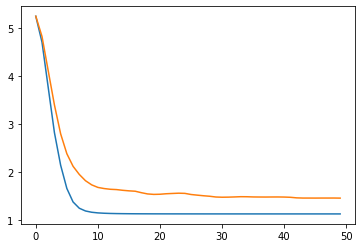

In [92]:

imle_pam_g = lambda _th: TopKPerturbAndMAPGumbIMLEGrad.apply(_th, 1.)
imle_pam_g_lcs = experiment(imle_pam_g, .5, n_rep=50)

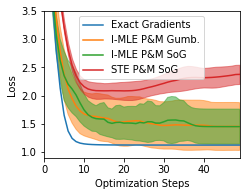

In [93]:
color_palette = plt.rcParams['axes.prop_cycle'].by_key()['color']

do_plots([imle_pam_g_lcs, imle_pam_lcs, ste_pam_lcs],
         [r'I-MLE P&M Gumb.', r'I-MLE P&M SoG', r'STE P&M SoG'],
         figsize=(3.5, 2.7), savename='ToyTopK.pdf')

In [94]:
n_states

252